In [15]:
import math
import numpy as np
import pandas as pd
from numpy.random.mtrand import RandomState
from recogym import Configuration
from recogym.agents import Agent
from sklearn.linear_model import LogisticRegression

from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
from recogym.agents import BanditCount, bandit_count_args, OrganicCount, organic_count_args
from recogym.agents import OrganicMFSquare, organic_mf_square_args, BanditMFSquare, bandit_mf_square_args
from recogym.agents import RandomAgent, random_args
from recogym.agents import FeatureProvider
from recogym import Configuration, DefaultContext, Observation
from recogym.envs.session import OrganicSessions
from recogym.evaluate_agent_sale import verify_agents_sale, plot_verify_agents_sale
from recogym.envs.utils_sale import *

import gym, recogym
from copy import deepcopy
from recogym import env_1_sale_args
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

# num_users = 1000
num_users = 100

env_1_sale_args['sigma_mu_organic'] = 0
env_1_sale_args['sigma_omega'] = 1
env_1_sale_args['random_seed'] = 42
env_1_sale_args['K'] = 5
env_1_sale_args['number_of_flips'] = 5
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

num_products = env_1_sale_args['num_products']

In [16]:
data = deepcopy(env).generate_logs(num_users)

from recogym.envs.utils_sale import CountFeatureProvider, build_train_data, LikelihoodAgent
config = Configuration(env_1_sale_args)
count_feature_provider = CountFeatureProvider(config=config)

user_states, actions, rewards, proba_actions = build_train_data(data, count_feature_provider)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.11it/s]


## Baselines

In [17]:
from recogym.envs.utils_sale import SingleActionAgent

# Initialise baselines
random_agent = RandomAgent(Configuration(random_args))
sales = [data["r"][data['a']==a].sum() for a in range(num_products)]
_, views = np.unique(data[data['z'] == 'organic']['v'], return_counts=True)
greedy_bandit = SingleActionAgent(np.argmax(sales), Configuration(env_1_sale_args))
greedy_organic = SingleActionAgent(np.argmax(views), Configuration(env_1_sale_args))
count_organic = OrganicCount()
count_bandit = BanditCount()

In [18]:
result_baselines = verify_agents_sale(
    env,
    number_of_users=2000,
    agents={
        'random agent': random_agent,
        'greedy_organic':greedy_organic,
        'greedy_bandit':greedy_bandit,
        'count_organic':count_organic,
        'count_bandit':count_bandit
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:06<00:00, 30.29it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 31.78it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:06<00:00, 29.89it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:04<00:00, 30.86it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 32.18it/s]


## Likelihood, user organic count, bandit & organic MF

In [19]:
%%time

count_product_views_feature_provider = CountFeatureProvider(config)

# likelihood agent
likelihood_logreg = LikelihoodAgent(count_product_views_feature_provider)
likelihood_logreg.train(data)

Estimated sales rate :  [0.00766871 0.01156069 0.01687764 0.01061008 0.01269394 0.01671309
 0.00853485 0.02164502 0.01759531 0.01699717]
Wall time: 3.36 s


In [20]:
# organic user-specific counter agent
organic_user_counter_agent = OrganicUserEventCounterAgent(
    Configuration({
        **organic_user_count_args,
        **env_1_sale_args,
        'select_randomly': True,
    })
)

# Organic and bandit MF
organic_mf = OrganicMFSquare()
bandit_mf = BanditMFSquare()

In [21]:
result = verify_agents_sale(
    env,
    number_of_users=2000,
    agents={
        'Organic User Count': organic_user_counter_agent,
        'Likelihood LogReg': likelihood_logreg,
        'Organic MF' : organic_mf,
        'Bandit MF' : bandit_mf
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:24<00:00, 23.79it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:40<00:00, 19.83it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:05<00:00, 30.77it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:47<00:00, 18.65it/s]


## Contextual bandit : vanilla, log & POEM

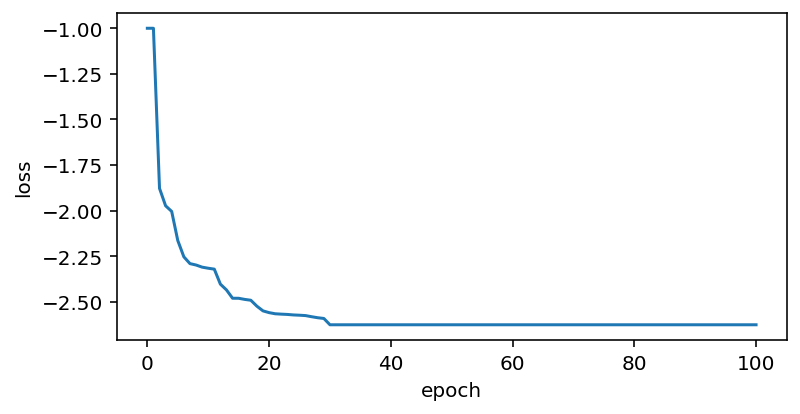

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:32<00:00, 21.63it/s]


In [22]:
from recogym.envs.utils_sale import ProductCountFeatureProvider, VanillaContextualBandit, MultinomialLogisticRegressionModel,build_rectangular_data
from recogym.envs.utils_sale import LogContextualBandit, PoemContextualBandit

rectangular_logs = build_rectangular_data(data, count_product_views_feature_provider)

vanilla_cb = VanillaContextualBandit({}, max_epoch=100)
vanilla_cb.train(rectangular_logs)
vanilla_cb.plot_loss_history()
result_AB_vanillaCB = verify_agents_sale(env, 2000, {'Contextual Bandit': vanilla_cb})


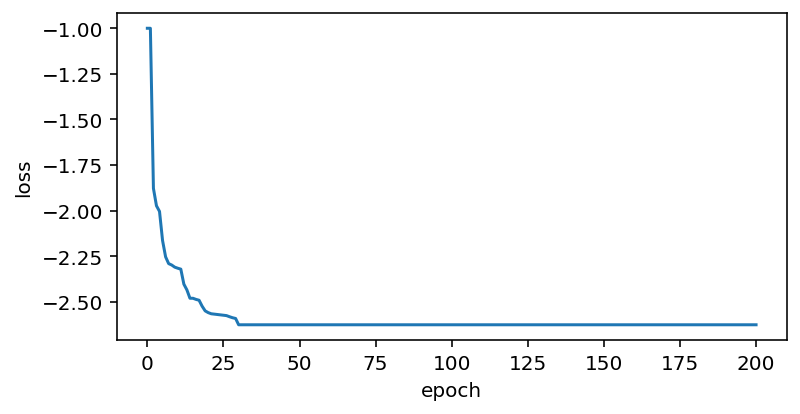

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:32<00:00, 21.70it/s]


In [23]:
log_cb = LogContextualBandit({}, max_epoch=200)
log_cb.train(rectangular_logs)
log_cb.plot_loss_history()
result_AB_LogCB = verify_agents_sale(env, 2000, {'Log Contextual Bandit': log_cb})

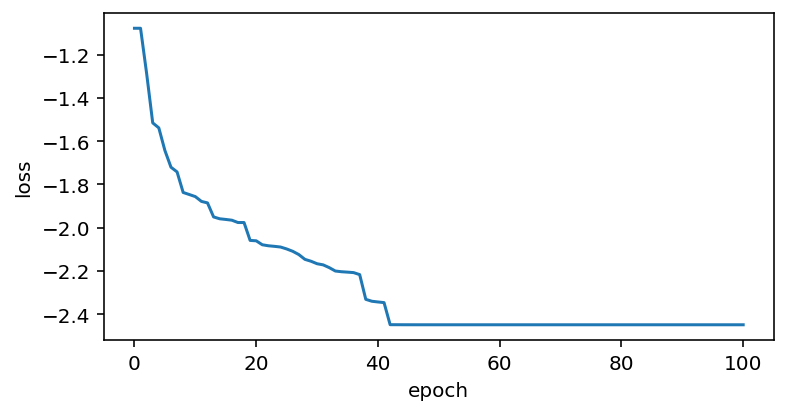

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:35<00:00, 20.90it/s]


In [24]:
poem = PoemContextualBandit({}, variance_penalization_factor=0.4, max_epoch=100)
poem.train(rectangular_logs)
poem.plot_loss_history()
result_AB_POEM = verify_agents_sale(env, 2000, {f'POEM': poem})

# Oracles
2 types of oracles : the ones looking at absolute sales, and the ones looking at incremental sales. Oracles have access to user embeddings, and some/all product features

## Oracles (looking at incremental sales)

#### Oracle that has access to the click, view, and sale proba of each product

In [26]:
from recogym.agents.sale_oracle import ClickViewSaleOracleAgent

cvs_oracle = ClickViewSaleOracleAgent(env=env)
cvs_oracle.reset()
result_cvs_oracle = verify_agents_sale(env, 2000, {'Click View Sale oracle': cvs_oracle}, agent_reset = True)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [05:50<00:00,  5.71it/s]


#### Oracle that has access to the click and sale proba of each product

In [27]:
from recogym.agents.sale_oracle import ClickSaleOracleAgent

cs_oracle = ClickSaleOracleAgent(env=env)
cs_oracle.reset()
result_cs_oracle = verify_agents_sale(env, 2000, {'Click Sale oracle': cs_oracle}, agent_reset = True)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [05:29<00:00,  6.08it/s]


#### Oracle that has access to the view and sale proba of each product

In [28]:
from recogym.agents.sale_oracle import ViewSaleOracleAgent
vs_oracle = ViewSaleOracleAgent(env=env)
vs_oracle.reset()
result_vs_oracle = verify_agents_sale(env, 2000, {'View Sale oracle': vs_oracle}, agent_reset = True)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [02:57<00:00, 11.27it/s]


#### Oracle that has access to the sale proba of each product only

In [29]:
from recogym.agents.sale_oracle import SaleOracleAgent
sale_oracle = SaleOracleAgent(env = env)
sale_oracle.reset()
result_AB_sale_oracle = verify_agents_sale(deepcopy(env), 2000, {'Sale oracle': sale_oracle})

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:23<00:00, 23.89it/s]


## Count oracles (just count the number of sales, not the incremental sales)

#### Oracle that has access to the click, view, and sale proba of each product

In [30]:
from recogym.agents.sale_count_oracle import ClickViewSaleCountOracleAgent

cvs_count_oracle = ClickViewSaleCountOracleAgent(env=env)
cvs_count_oracle.reset()
result_cvs_count_oracle = verify_agents_sale(env, 2000, {'Click View Sale Count oracle': cvs_count_oracle}, agent_reset = True)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [06:28<00:00,  5.15it/s]


#### Oracle that has access to the click and sale proba of each product

In [31]:
from recogym.agents.sale_count_oracle import ClickSaleCountOracleAgent

cs_count_oracle = ClickSaleCountOracleAgent(env=env)
cs_count_oracle.reset()
result_cs_count_oracle = verify_agents_sale(env, 2000, {'Click Sale Count oracle': cs_count_oracle}, agent_reset = True)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [05:54<00:00,  5.64it/s]


#### Oracle that has access to the view, and sale proba of each product

In [32]:
from recogym.agents.sale_count_oracle import ViewSaleCountOracleAgent
vs_count_oracle = ViewSaleCountOracleAgent(env=env)
vs_count_oracle.reset()
result_vs_count_oracle = verify_agents_sale(env, 2000, {'View Sale Count oracle': vs_count_oracle}, agent_reset = True)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [02:53<00:00, 11.54it/s]


#### Oracle that has access to the sale proba of each product only

In [33]:
from recogym.agents.sale_count_oracle import SaleCountOracleAgent
sale_count_oracle = SaleCountOracleAgent(env = env)
sale_count_oracle.reset()
result_AB_sale_count_oracle = verify_agents_sale(deepcopy(env), 2000, {'Sale Count oracle': sale_count_oracle})

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [02:08<00:00, 15.51it/s]


## Concatenate results

In [34]:
result_list = [result_baselines, result, 
               result_AB_vanillaCB, result_AB_LogCB, result_AB_POEM, 
               result_AB_sale_oracle, result_cs_oracle, result_vs_oracle, result_cvs_oracle,
               result_AB_sale_count_oracle, result_cs_count_oracle, result_vs_count_oracle, result_cvs_count_oracle
              ]
result_list = [list(res.values()) for res in result_list]
# for each type of metrics, concatenate the results for all agents
result_concat = (pd.concat([res[0] for res in result_list]),
                 pd.concat([res[1] for res in result_list]),
                 pd.concat([res[2] for res in result_list]),
                 pd.concat([res[3] for res in result_list]),
                 pd.concat([res[4] for res in result_list]))

In [35]:
# result_concat[0]
for i, res in enumerate(result_concat):
    print(list(result.keys())[i])
    display(res)

sale rate


,Agent,0.025,0.500,0.975
0,random agent,0.013594,0.014157,0.014736
1,greedy_organic,0.012444,0.012995,0.013562
2,greedy_bandit,0.013377,0.013948,0.014534
3,count_organic,0.013536,0.014098,0.014675
4,count_bandit,0.012776,0.013330,0.013900
0,Organic User Count,0.013970,0.014557,0.015161
1,Likelihood LogReg,0.012898,0.013467,0.014052
2,Organic MF,0.013550,0.014135,0.014736
3,Bandit MF,0.013375,0.013944,0.014528
0,Contextual Bandit,0.013526,0.014092,0.014673


CTR


,Agent,0.025,0.500,0.975
0,random agent,0.009520,0.009994,0.010482
1,greedy_organic,0.008625,0.009086,0.009562
2,greedy_bandit,0.009485,0.009967,0.010464
3,count_organic,0.008496,0.008943,0.009405
4,count_bandit,0.008732,0.009192,0.009668
0,Organic User Count,0.009876,0.010372,0.010884
1,Likelihood LogReg,0.009234,0.009717,0.010216
2,Organic MF,0.009065,0.009545,0.010042
3,Bandit MF,0.009052,0.009522,0.010007
0,Contextual Bandit,0.009454,0.009928,0.010419


Tot sales


,Agent,TotSales
0,random agent,2132
1,greedy_organic,2132
2,greedy_bandit,2132
3,count_organic,2132
4,count_bandit,2132
0,Organic User Count,2216
1,Likelihood LogReg,2216
2,Organic MF,2216
3,Bandit MF,2216
0,Contextual Bandit,2284


Share user with sale


,Agent,0.025,0.500,0.975
0,random agent,0.495085,0.516989,0.538849
1,greedy_organic,0.476110,0.498001,0.519898
2,greedy_bandit,0.489090,0.510993,0.532868
3,count_organic,0.489090,0.510993,0.532868
4,count_bandit,0.493086,0.514990,0.536855
0,Organic User Count,0.493586,0.515490,0.537354
1,Likelihood LogReg,0.464640,0.486509,0.508413
2,Organic MF,0.497584,0.519487,0.541340
3,Bandit MF,0.486093,0.507995,0.529876
0,Contextual Bandit,0.491587,0.513491,0.535360


Share sale after click


,Agent,0.025,0.500,0.975
0,random agent,0.230691,0.251269,0.272621
1,greedy_organic,0.221674,0.243426,0.266094
2,greedy_bandit,0.243110,0.264494,0.286644
3,count_organic,0.220014,0.241403,0.263689
4,count_bandit,0.231507,0.253285,0.275921
0,Organic User Count,0.239411,0.260447,0.282244
1,Likelihood LogReg,0.235019,0.256766,0.279348
2,Organic MF,0.226258,0.247995,0.270618
3,Bandit MF,0.248554,0.270526,0.293274
0,Contextual Bandit,0.229913,0.250673,0.272225


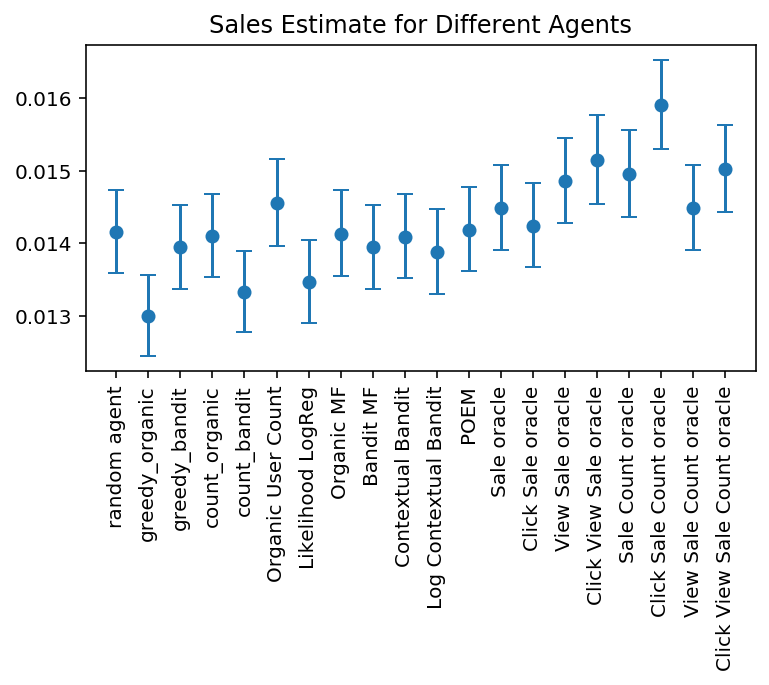

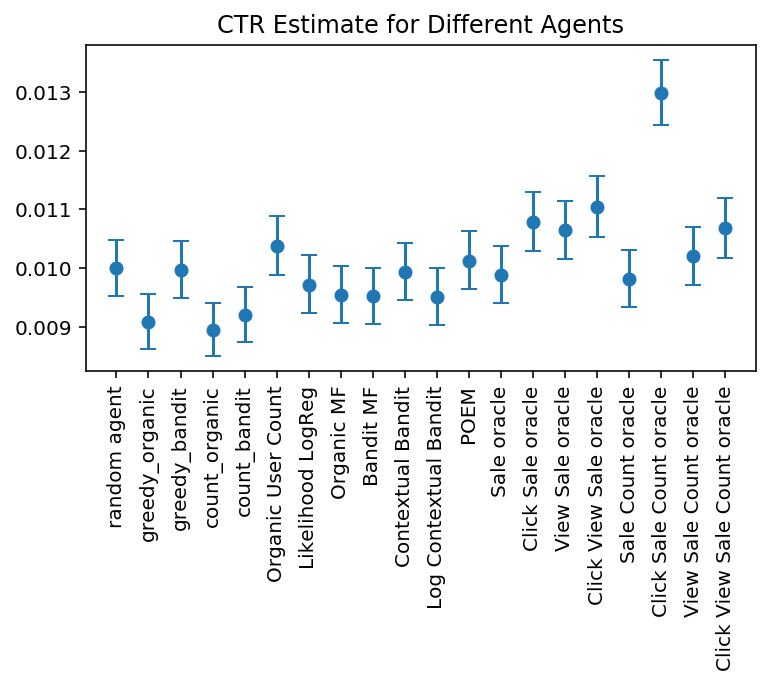

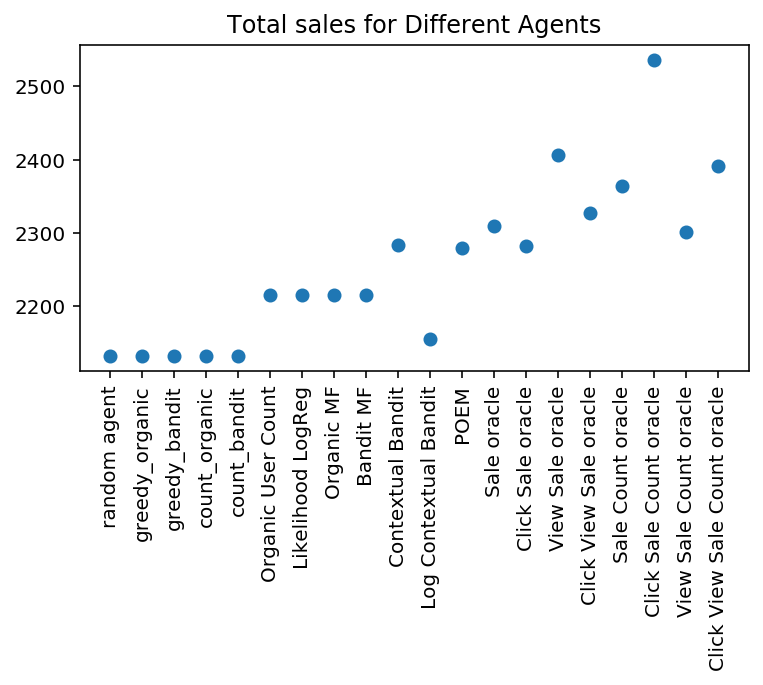

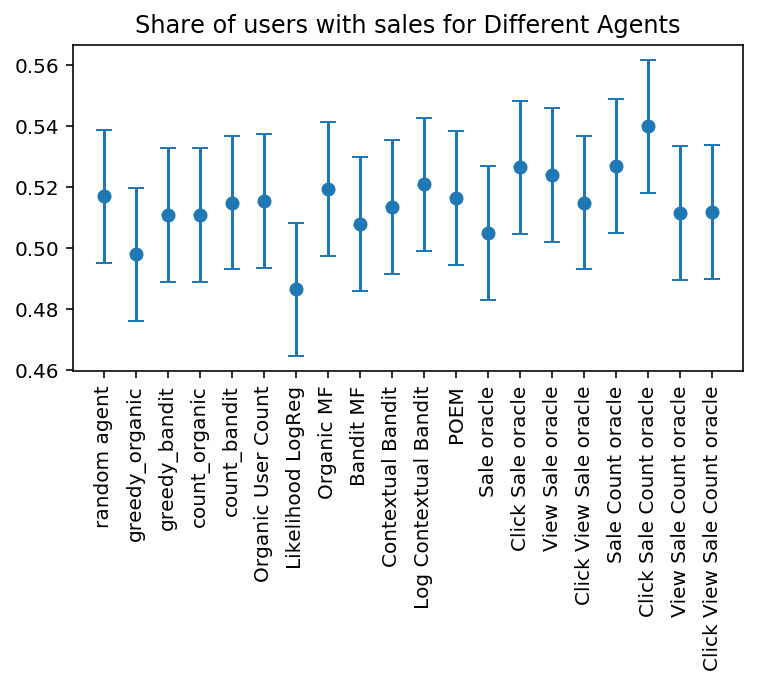

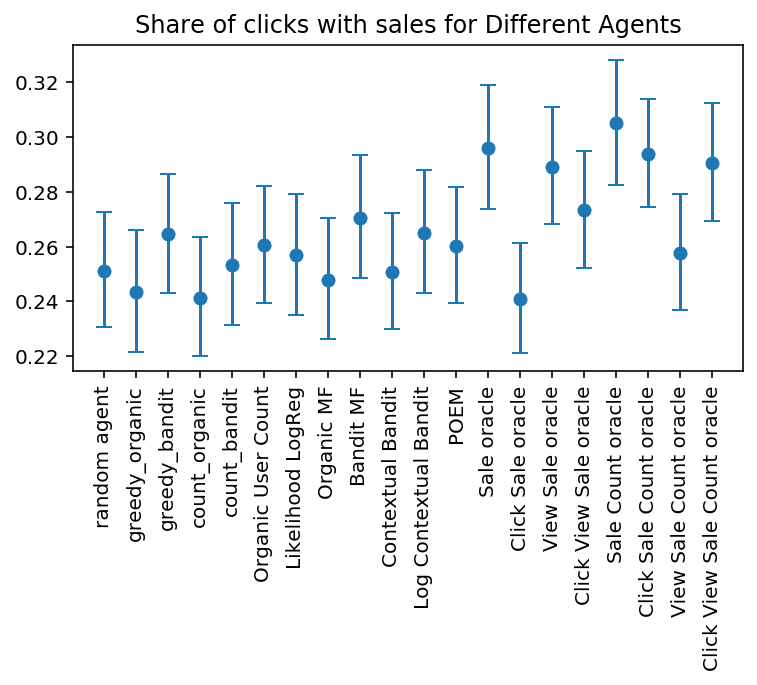

In [36]:
fig = plot_verify_agents_sale(*result_concat)
plt.show()